# Linear Regression Model

##### Author: Holly Bok

### Import of Packages and Clean Dataset

In [1]:
# Importing packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm

%matplotlib inline

In [2]:
train = pd.read_csv('datasets/clean_train.csv')
test = pd.read_csv('datasets/test.csv')

### EDA and Feature Selection

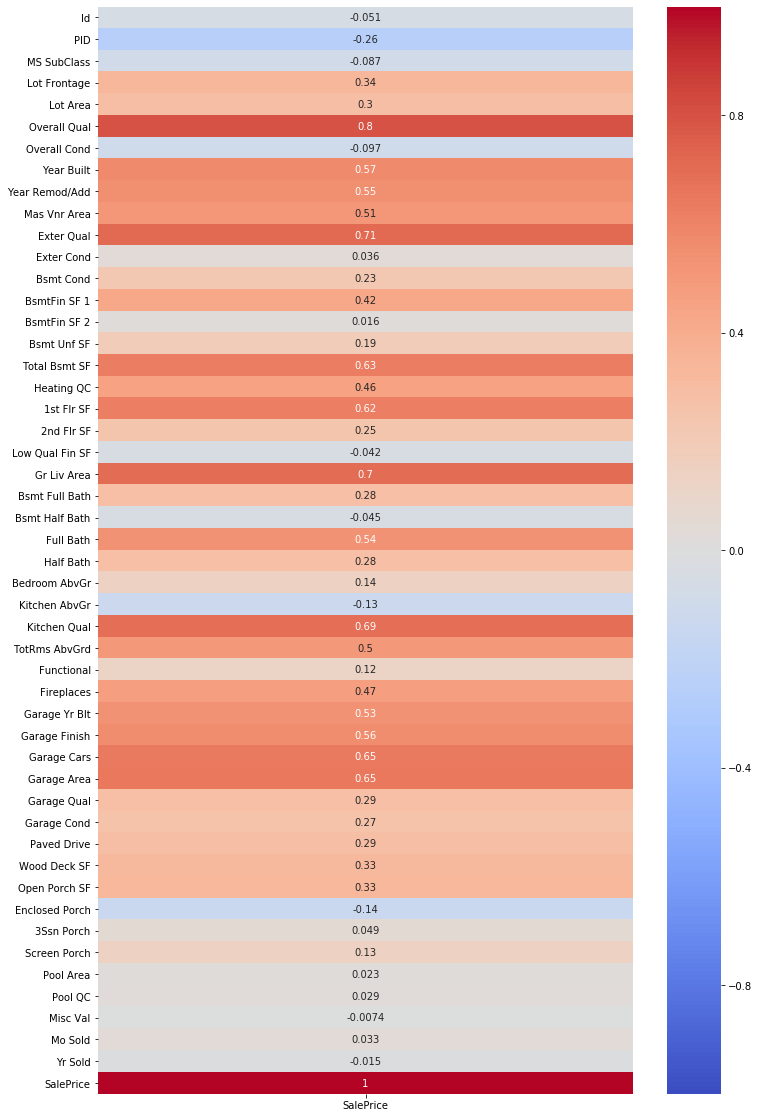

In [3]:
# Using seaborn heatbmap to identify the strength of the relationships between all independent variables and
# Sale Price

plt.figure(figsize=(12,20))
sns.heatmap(train.corr()[['SalePrice']], annot=True, cmap='coolwarm', vmax=1, vmin=-1);

**Stronger correlations with Sales Price are found with the following indepdent variables:** Overral Quality (.8), Exterior Quality (.71), Ground living area (.7), Kitchen Qual (0.69), Garage Cars (.65), Garage Area (.65), Total basement SF (.63), 1st floor sqft (.62), Year Built (.57), Garage Finish (.56), Year Remodeled (.55), Full Bath (.54), Garage year built (.53), Masonry Veneer Area (.51), Total above ground rooms (.5), Fireplace (.47), Heating QC (.46), and Porch Sqft (.41)


A lot of this information contains redundencies. For example, garage cars, garage area, and
garage finish are all included, but they provide a lot of the same information. For my model, I will only be
including garage area (as it has the highest correlation) and describes very similar information as the
rest of the garage size / type categories. More redundancies are found with total above ground living area (in sqft) with both porch sq_ft and 1st floor sqft. Garage year built is also likely redundant to year built and/or year remodeled. Heating and fireplace (the two lowest correlated of our selections) will be removed in the interest of avoiding overfitting. Confidence levels for all remaining variables are below alpha = .05* except for total above ground rooms. Total above ground rooms will be deleted. 

**My model will include the following variables: Overall Quality (.8), Exterior Quality (.71), Above ground living area (.7), Kitchen Qual (0.69), Garage Area (.65), Total basement SF (.63), Year Built (.57), Year Remodeled (.55), Full Bath (.54), and Masonry Veneer Area (.51)**

*See confidence intervals under the "Model Scoring" subheader below

In [4]:
# Making a new dataframe called "train_1" with only the variables of interest.
# Double checking data types

train_1 = train[['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'Garage Area', 
                 'Total Bsmt SF', 'Year Built', 'Year Remod/Add', 'Full Bath', 'Mas Vnr Area',  'SalePrice']]
train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 11 columns):
Overall Qual      2051 non-null int64
Exter Qual        2051 non-null int64
Gr Liv Area       2051 non-null int64
Kitchen Qual      2051 non-null int64
Garage Area       2050 non-null float64
Total Bsmt SF     2050 non-null float64
Year Built        2051 non-null int64
Year Remod/Add    2051 non-null int64
Full Bath         2051 non-null int64
Mas Vnr Area      2029 non-null float64
SalePrice         2051 non-null int64
dtypes: float64(3), int64(8)
memory usage: 176.4 KB


In [5]:
# Checking for null values in train_1
# 22 null values appear for Masonry Veneer Area, and 1 null value each appears in Garage Area and Total Basement
# SF. Since these values are for continous area (square footage) I will assume that homes with null values have 
# no masonry veneer area. The same is true for Garage Area and Total Basement SF.
# Raplacing all null values with a '0' to represent 0 square feet.

train_1.isnull().sum()
train_1 = train_1.fillna(0)
train_1.isnull().sum()

Overall Qual      0
Exter Qual        0
Gr Liv Area       0
Kitchen Qual      0
Garage Area       0
Total Bsmt SF     0
Year Built        0
Year Remod/Add    0
Full Bath         0
Mas Vnr Area      0
SalePrice         0
dtype: int64

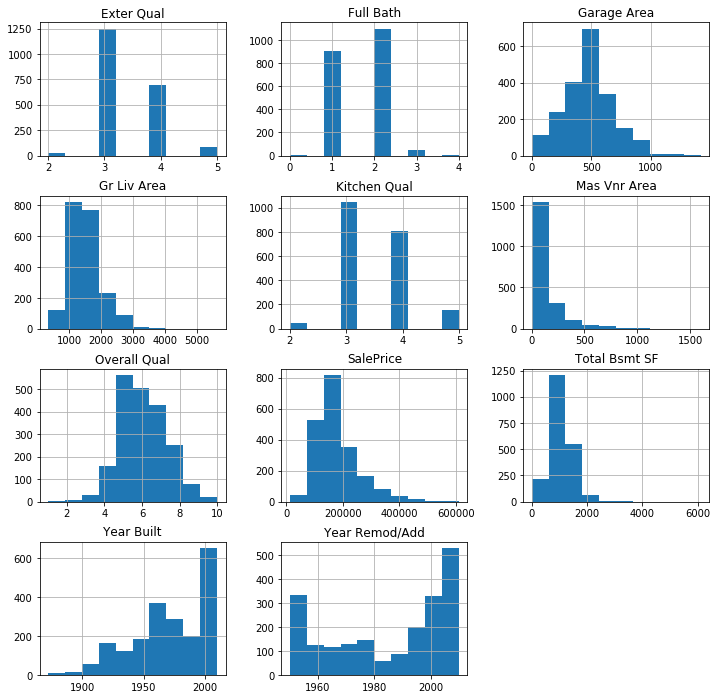

In [6]:
# Creating histograms for all independent variables to observe the shape of the distributions

train_1.hist(figsize=(12,12));

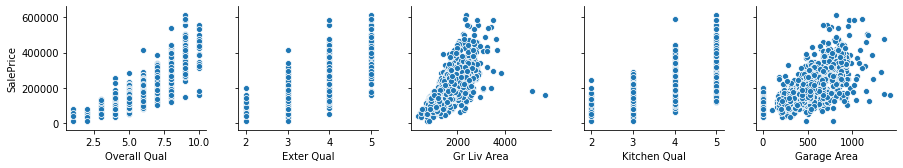

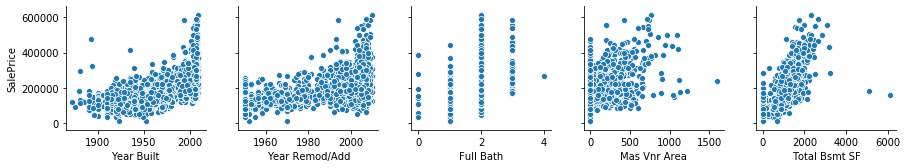

In [7]:
# Creating pairplots for all independent variables in relation to Sale Price to check the shapes of relationships

sns.pairplot(train_1, y_vars=['SalePrice'],
             x_vars = ['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'Garage Area']);
sns.pairplot(train_1, y_vars=['SalePrice'],
             x_vars = ['Year Built', 'Year Remod/Add', 'Full Bath', 'Mas Vnr Area',  'Total Bsmt SF']);


In [8]:
# Several of the pairplots have outliers that are causing heavy heteroskedasticity. To improve this, outliers are
# removed. Properties are removed for the following reasons:
# Above Ground Living Area ('Gr Liv Area') above 5000 square feet (Properties 960 and 1885)
# Total Basement Square Feet above 4000 square feet. The two properties matching this criteria are the same 
# properties that are eliminated based on criteria for Above Ground Living Area.
# Masonry Veneer Area above 1500 square feet (Property 1409)
# Full Bath above 3 baths (Properties 1566, 1605)
# Properties built before 1900 that sold for above 200k (Properties 1035, 1141, and 1939)

train_1.drop([960], axis=0, inplace= True) 
train_1.drop([1885], axis=0, inplace= True)
train_1.drop([1409], axis=0, inplace= True)
train_1.drop([1566], axis=0, inplace= True)
train_1.drop([1605], axis=0, inplace= True)
train_1.drop([1035], axis=0, inplace= True)
train_1.drop([1141], axis=0, inplace= True)
train_1.drop([1939], axis=0, inplace= True)

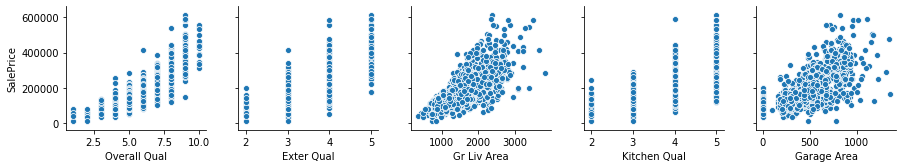

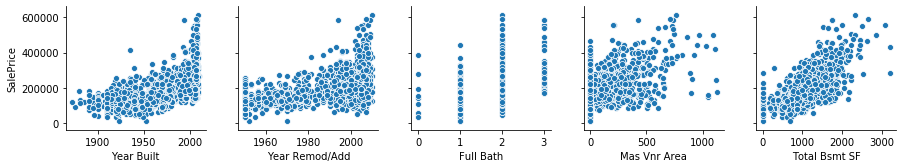

In [9]:
# Replotting features to analyze changes in the shapes of relationships. 

sns.pairplot(train_1, y_vars=['SalePrice'],
             x_vars = ['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'Garage Area']);
sns.pairplot(train_1, y_vars=['SalePrice'],
             x_vars = ['Year Built', 'Year Remod/Add', 'Full Bath', 'Mas Vnr Area',  'Total Bsmt SF']);

In [10]:
# Transorming the 2 variables with the highest correlation to Sale Price (Overall Quality and Exterior Quality)
# as well a transforming Sale Price
# Transforming by using np.log

train_1['SalePrice'] = train_1['SalePrice'].map(np.log)
train_1['Overall Qual'] = train_1['Overall Qual'].map(np.log)
train_1['Exter Qual'] = train_1['Exter Qual'].map(np.log)

### Train-Test-Split / Model Fitting

In [11]:
# Creating X and y variables to fit to the model:

X = train_1.drop('SalePrice', axis=1)
y = train_1['SalePrice']

In [12]:
# Running train_test_split on my variables to split data into test and train. Random seed is set to 42.

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

In [13]:
# Instantiating and fitting a linear regression model called "my_model"

my_model = LinearRegression()
my_model.fit(X_train, y_train);

In [14]:
# Generating and saving predictions for train_1 test data
# Calculating and saving residuals

predictions = my_model.predict(X_test)
residuals = y_test - predictions

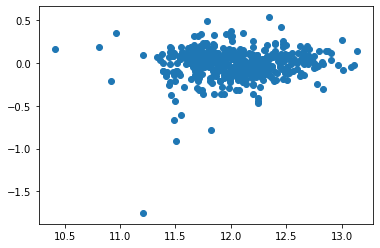

In [15]:
# Plotting predictions vs. residuals to assess homoskedaticity. While there is some heteroskedasticity this model
# is fairly homoskedastic. 

plt.scatter(predictions, residuals);

## Model Scoring

In [16]:
# Using cross_val_score().mean() to find the average R2 cross value score for training data with 5 folds

cross_val_score(my_model, X_train, y_train, cv=5).mean()

0.8644905636927491

In [17]:
# Using .score() to get the R2 score for all training data

my_model.score(X_train, y_train)

0.8705915566195076

In [18]:
# Using .score() to get the R2 score for the test data

my_model.score(X_test, y_test)

0.8319067601632991

In [19]:
# Checking the beta values for each independent variable

my_model.coef_

array([ 4.34431377e-01,  4.56463175e-02,  3.06204784e-04,  5.34801723e-02,
        1.97729655e-04,  1.86099730e-04,  2.07382710e-03,  1.90469392e-03,
       -5.42715928e-02,  3.26297695e-05])

In [20]:
# Exploring the significance of the relationships between independent variables and the dependent variable

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     1254.
Date:                Thu, 16 Jan 2020   Prob (F-statistic):               0.00
Time:                        20:26:02   Log-Likelihood:                 932.66
No. Observations:                2043   AIC:                            -1843.
Df Residuals:                    2032   BIC:                            -1781.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.6700      0.472      5.658      0.000       1.744       3.595
Overall Qual       0.4618      0.022     21.291      0.000       0.419       0.504
Exter Qual         0.0561      0.035      1.623      0.105      -0.012       0.124
Gr Liv Area        0.0003   1.07e-05     27.348      0.000       0.000       0.000
Kitchen Qual       0.0494      0.008      6.078      0.000       0.033       0.065
Garage Area        0.0002    2.1e-05     10.056      0.000       0.000       0.000
Total Bsmt SF      0.0002   1.01e-05     17.939      0.000       0.000       0.000
Year Built         0.0020      0.000     11.341      0.000       0.002       0.002
Year Remod/Add     0.0019      0.000      7.702      0.000       0.001       0.002
Full Bath         -0.0472      0.009     -5.214      0.000      -0.065      -0.029
Mas Vnr Area    4.709e-05   2.33e-05      2.017      0.044    1.31e-06    9.29e-05
==============================================================================
Omnibus:                      851.278   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13343.988
Skew:                          -1.537   Prob(JB):                         0.00
Kurtosis:                      15.137   Cond. No.                     4.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Generating Predictions for Test Dataset


Making changes to the "test" dataframe to align columns and datatypes with the train_1 data in my_model. The test dataframe contains no values for Sale Price. Predictions for Sale Price will be generated and formatted for submission to the DSI 10 Linear Regression Challenge.

In [21]:
# Converting the test dataframe columns to match train dataframe columns for Kitchen and Exterior Quality
# Creating a function called rank_test_column that will rank and convert test column variables to integers

def rank_test_column(column):   
    test[column] = test[column].str.replace('Ex', '5')
    test[column] = test[column].str.replace('Gd', '4')
    test[column] = test[column].str.replace('TA', '3')
    test[column] = test[column].str.replace('Fa', '2')
    test[column] = test[column].str.replace('Po', '1')
    test[column] = test[column].fillna(0)
    test[column] = test[column].astype(int)
    return
rank_test_column('Kitchen Qual')
rank_test_column('Exter Qual')

In [22]:
# Transforming to log columns:

test['Overall Qual'] = test['Overall Qual'].map(np.log)
test['Exter Qual'] = test['Exter Qual'].map(np.log)

In [23]:
# Filling in null values as 0 in the test dataframe

test.isnull().sum()
test = test.fillna(0)
test.isnull().sum()

Id              0
PID             0
MS SubClass     0
MS Zoning       0
Lot Frontage    0
               ..
Misc Feature    0
Misc Val        0
Mo Sold         0
Yr Sold         0
Sale Type       0
Length: 80, dtype: int64

In [24]:
# Generating predictions for Sale Price for the test dataframe and saving this as a new list called "Preds"
# Converting preds back into the orginal, non-log units using np.exp()
# Saving the predictions in the orginal units as a a new column called "SalePrice"

features = ['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'Garage Area', 'Total Bsmt SF', 'Year Built', 'Year Remod/Add', 'Full Bath', 'Mas Vnr Area']
preds = my_model.predict(test[features])
preds_og_units = np.exp(preds)
test['SalePrice'] = preds_og_units

In [25]:
# Creating a new dataframe called "holly_predictions" that is formatted as per the instructions for the Kaggle
# competition (formatted as a 2 column dataframe with a column for property ID and a column for Sale Price)
# Writing holly_predicitons to CSV.

holly_predictions = test[['Id','SalePrice']]
holly_predictions.to_csv('datasets/Holly_Preds_LR.csv', index=False)